In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from core.model import Model

import json

In [2]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

In [3]:
df = pd.read_csv('./data/sh600031.csv')  # 读取股票文件
df.set_index('date', inplace=True)

In [4]:
df.drop(['volume'],axis=1,inplace=True)

In [5]:
df.head()

open   high    low  close
date                                  
2003-07-03  23.00  23.00  20.10  21.30
2003-07-04  21.30  22.18  21.05  21.84
2003-07-07  21.90  21.96  21.51  21.80
2003-07-08  21.80  22.22  21.70  21.91
2003-07-09  21.75  22.65  21.70  22.47

In [6]:
# 获取DataFrame中的数据，形式为数组array形式
values = df.values
# 确保所有数据为float类型
values = values.astype('float32')

In [7]:
# 定义series_to_supervised()函数
# 将时间序列转换为监督学习问题
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    将时间序列框定为有监督的学习数据集。
        论据：
        数据：作为列表或NumPy数组的观察序列。
        n_in：作为输入的滞后观测数（X）。
        n_out：作为输出的观察数（y）。
        dropnan：布尔值，决定是否删除具有NaN值的行。
    返回：
    pd.DataFrame(用于监督学习)
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
# 将时间序列转换为监督学习问题
reframed = series_to_supervised(values, 1, 1)

In [9]:
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)    var1(t)    var2(t)  \
1  23.000000  23.000000  20.100000  21.299999  21.299999  22.180000   
2  21.299999  22.180000  21.049999  21.840000  21.900000  21.959999   
3  21.900000  21.959999  21.510000  21.799999  21.799999  22.219999   
4  21.799999  22.219999  21.700001  21.910000  21.750000  22.650000   
5  21.750000  22.650000  21.700001  22.469999  22.330000  22.910000   

     var3(t)    var4(t)  
1  21.049999  21.840000  
2  21.510000  21.799999  
3  21.700001  21.910000  
4  21.700001  22.469999  
5  22.299999  22.650000

In [10]:
# 删除不想预测的特征列，这里只预测收盘价
# 所以删除的是var1(t),var2(t),var3(t),
reframed.drop(['var1(t)', 'var2(t)', 'var3(t)'], axis=1, inplace=True)

In [11]:
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)    var4(t)
1  23.000000  23.000000  20.100000  21.299999  21.840000
2  21.299999  22.180000  21.049999  21.840000  21.799999
3  21.900000  21.959999  21.510000  21.799999  21.910000
4  21.799999  22.219999  21.700001  21.910000  22.469999
5  21.750000  22.650000  21.700001  22.469999  22.650000

In [12]:
# 划分训练集和测试集
train = reframed.iloc[:int(len(reframed) * 0.85), :].values
test = reframed.iloc[int(len(reframed) * 0.85):, :].values
# 划分训练集和测试集的输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# 转化为三维数据
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [13]:
configs = json.load(open('./test_1/config.json', 'r'))

In [14]:
model = Model()
model.build_model(configs, train_X.shape[1], train_X.shape[2])

[Model] Model Compiled
Time taken: 0:00:01.015917


In [15]:
# 内存中训练
model.train(
    train_X,
    train_y,
    epochs=configs['training']['epochs'],
    batch_size=configs['training']['batch_size'],
    validation_data=(test_X, test_y),
    verbose=configs['training']['verbose'],
    shuffle=configs['training']['shuffle'],
    validation_freq=configs['training']['validation_freq'],
    save_dir=configs['model']['save_dir']
)


[Model] Training Started
[Model] 50 epochs, 64 batch size
Epoch 1/50
59/59 [==============================] - 10s 43ms/step - loss: 299.4852 - val_loss: 156.6487
Epoch 2/50
59/59 [==============================] - 1s 14ms/step - loss: 143.6328 - val_loss: 95.6540
Epoch 3/50
59/59 [==============================] - 1s 14ms/step - loss: 89.4762 - val_loss: 54.0653
Epoch 4/50
59/59 [==============================] - 1s 15ms/step - loss: 63.8508 - val_loss: 32.0166
Epoch 5/50
59/59 [==============================] - 1s 14ms/step - loss: 47.1594 - val_loss: 20.1891
Epoch 6/50
59/59 [==============================] - 1s 16ms/step - loss: 37.1992 - val_loss: 13.1035
Epoch 7/50
59/59 [==============================] - 1s 14ms/step - loss: 29.6858 - val_loss: 9.1565
Epoch 8/50
59/59 [==============================] - 1s 14ms/step - loss: 25.0098 - val_loss: 6.9987
Epoch 9/50
59/59 [==============================] - 1s 14ms/step - loss: 20.6006 - val_loss: 5.2019
Epoch 10/50
59/59 [=============

In [16]:
y_predict = model.predict_point_by_point(test_X)

[Model] Predicting Point-by-Point...


In [20]:
test_y = test_y.reshape((len(test_y), 1))

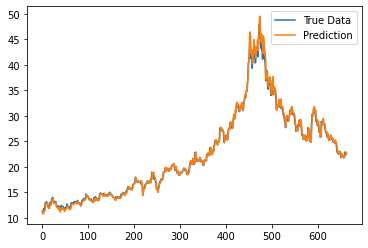

In [21]:
plot_results(y_predict, test_y)